In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set the paths to the directories
train_dir = 'Teeth_Dataset/Training'
val_dir = 'Teeth_Dataset/Validation'
test_dir = 'Teeth_Dataset/Testing'

# Load the datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images to a standard size (224x224)
    batch_size=32,          # Load images in batches
    label_mode='int'        # Labels as integers
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [3]:
for images, labels in train_ds.take(1):
    print("Train dataset batch:")
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print("Validation dataset batch:")
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")


Train dataset batch:
Image shape: (32, 224, 224, 3)
Label shape: (32,)
Validation dataset batch:
Image shape: (32, 224, 224, 3)
Label shape: (32,)


Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


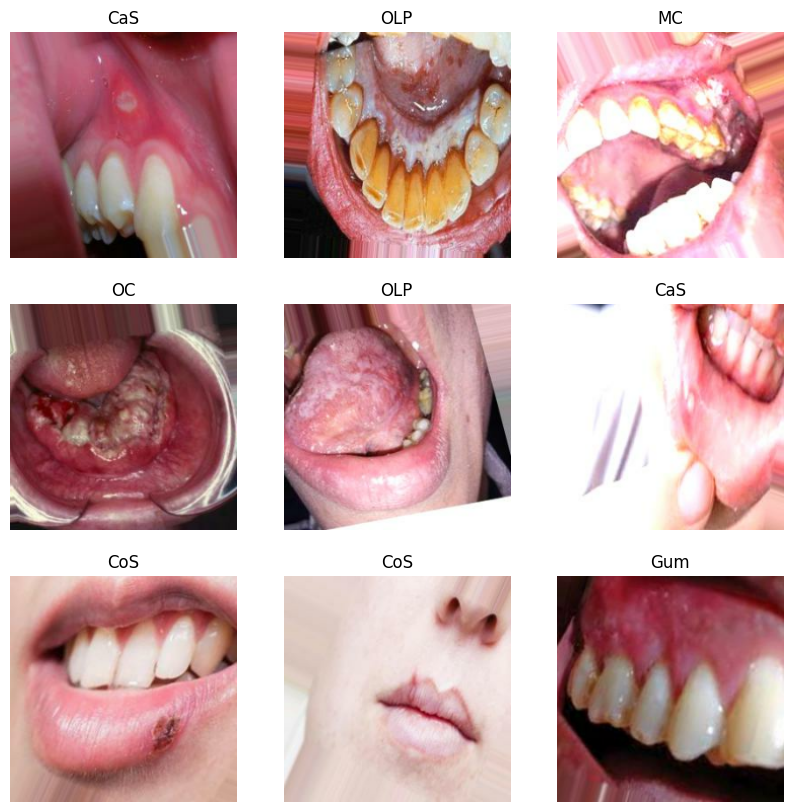

In [4]:
# Print the class names
class_names = train_ds.class_names
print("Class names:", class_names)



def show_samples(dataset, class_names, num_samples=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_samples):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

# Visualize samples from the training dataset
show_samples(train_ds, class_names)


Class distribution in Training Dataset: {'CaS': 480, 'CoS': 450, 'Gum': 360, 'MC': 540, 'OC': 324, 'OLP': 540, 'OT': 393}
Class distribution in Testing Dataset: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}
Class distribution in Validation Dataset: {'CaS': 160, 'CoS': 149, 'Gum': 120, 'MC': 180, 'OC': 108, 'OLP': 180, 'OT': 131}


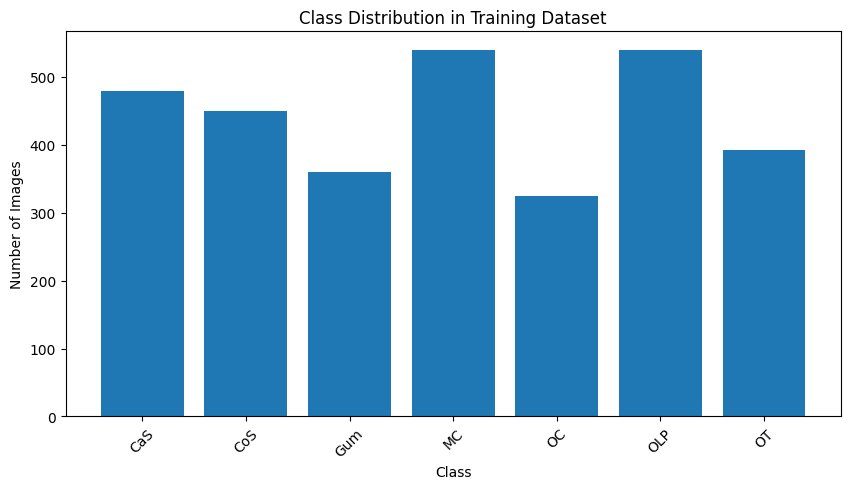

In [6]:
# Calculate class distribution
def calculate_class_distribution(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for _, labels in dataset:
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Calculate class distribution for training dataset
train_class_distribution = calculate_class_distribution(train_ds, class_names)
print("Class distribution in Training Dataset:", train_class_distribution)

# Calculate class distribution for testing dataset
test_class_distribution = calculate_class_distribution(test_ds, class_names)
print("Class distribution in Testing Dataset:", test_class_distribution)

# Calculate class distribution for validation dataset
val_class_distribution = calculate_class_distribution(val_ds, class_names)
print("Class distribution in Validation Dataset:", val_class_distribution)

# Visualize the distribution of training data using a bar plot
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values())
plt.title("Class Distribution in Training Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Normalizing the datasets (by scaling pixel values from [0, 255] to [0, 1])
def normalize_dataset(dataset):
    return dataset.map(lambda x, y: (x / 255.0, y))

# Apply normalization to the datasets
train_ds = normalize_dataset(train_ds)
val_ds = normalize_dataset(val_ds)
test_ds = normalize_dataset(test_ds)


In [10]:
# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  
    layers.RandomRotation(0.1),       # Limited rotation of ±10 degrees
    layers.RandomZoom(0.2),           # Zoom in/out by up to 20%
    layers.RandomContrast(0.2),       # Adjust contrast randomly
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [12]:
# Shuffle and prefetch the datasets
train_ds = train_ds.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [16]:
model.compile(
    optimizer='adam',  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=5,                
    restore_best_weights=True   
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping],  
    verbose=1
)

Epoch 1/30
97/97 [==============================] - 25s 59ms/step - loss: 1.8850 - accuracy: 0.2258 - val_loss: 1.7745 - val_accuracy: 0.2928
Epoch 2/30
97/97 [==============================] - 19s 52ms/step - loss: 1.7427 - accuracy: 0.3223 - val_loss: 1.6375 - val_accuracy: 0.4008
Epoch 3/30
97/97 [==============================] - 18s 51ms/step - loss: 1.5825 - accuracy: 0.3891 - val_loss: 1.6298 - val_accuracy: 0.3949
Epoch 4/30
97/97 [==============================] - 19s 51ms/step - loss: 1.4283 - accuracy: 0.4593 - val_loss: 1.3550 - val_accuracy: 0.5019
Epoch 5/30
97/97 [==============================] - 18s 52ms/step - loss: 1.3399 - accuracy: 0.4940 - val_loss: 1.1955 - val_accuracy: 0.5661
Epoch 6/30
97/97 [==============================] - 19s 51ms/step - loss: 1.1785 - accuracy: 0.5478 - val_loss: 1.1119 - val_accuracy: 0.5934
Epoch 7/30
97/97 [==============================] - 19s 52ms/step - loss: 1.0438 - accuracy: 0.6197 - val_loss: 1.0051 - val_accuracy: 0.6586
Epoch 

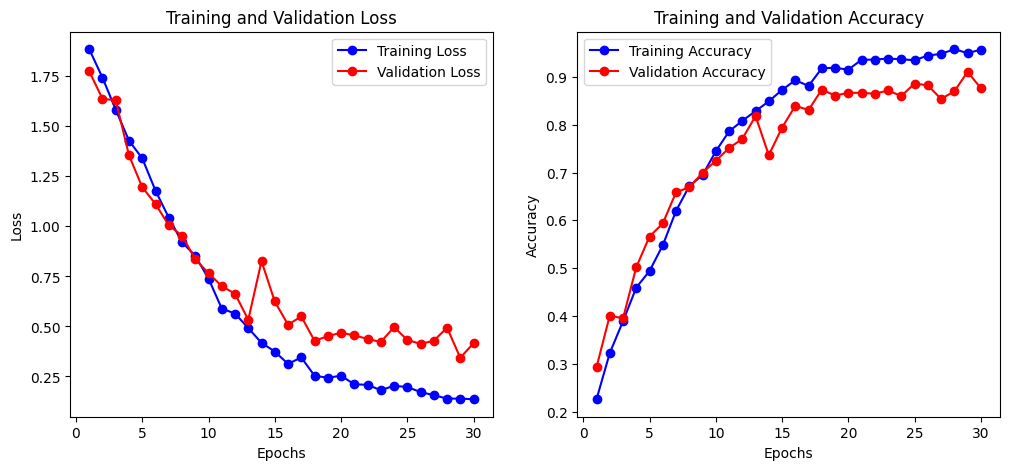

In [19]:
# Extract loss and accuracy from the history object
epochs = range(1, len(history.history['loss']) + 1)

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [21]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


33/33 [==============================] - 1s 18ms/step - loss: 0.4796 - accuracy: 0.8765
Test Loss: 0.4795559048652649
Test Accuracy: 0.8764591217041016


In [22]:
import numpy as np

# Collect true labels and predictions
y_true = []
y_pred = []

# Iterate through the test dataset to collect true labels and predictions
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=-1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 16ms/step


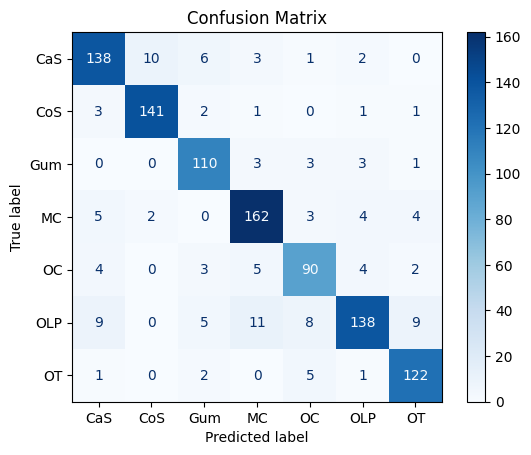

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [32]:
# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

         CaS       0.86      0.86      0.86       160
         CoS       0.92      0.95      0.93       149
         Gum       0.86      0.92      0.89       120
          MC       0.88      0.90      0.89       180
          OC       0.82      0.83      0.83       108
         OLP       0.90      0.77      0.83       180
          OT       0.88      0.93      0.90       131

    accuracy                           0.88      1028
   macro avg       0.87      0.88      0.88      1028
weighted avg       0.88      0.88      0.88      1028



In [30]:
# Save model for future use
model.save("TeethClassification.h5")

In [31]:
# Load the model
loaded_model = tf.keras.models.load_model('TeethClassification.h5')


In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = 'infere_img2.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model's input size

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Normalize the image array (scale pixel values to [0, 1])
img_array = img_array / 255.0

# Add a batch dimension (make it a 4D tensor)
img_array = np.expand_dims(img_array, axis=0)

# Verify the shape of the image
print(img_array.shape)  # Should be (1, 224, 224, 3)


(1, 224, 224, 3)


In [40]:
# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)

# Map predicted class index to class name
predicted_class_name = class_names[predicted_class[0]]
print(f'Predicted Class: {predicted_class_name}')

1/1 [==============================] - 0s 31ms/step
Predicted Class: OC
